# Landsat Processing
Created by: Oriana Chegwidden

In [8]:
# %load_ext autoreload
# %autoreload 2
import boto3
from rasterio.session import AWSSession
from s3fs import S3FileSystem
aws_session = AWSSession(boto3.Session(profile_name='default'), 
                         requester_pays=True)
fs = S3FileSystem(profile='default', requester_pays=True)

from osgeo.gdal import VSICurlClearCache
VSICurlClearCache() 
import rasterio as rio
import xarray as xr
import dask
import os
import fsspec
import geopandas as gpd
import regionmask as rm
# from satsearch import Search
from matplotlib.pyplot import imshow
from intake import open_stac_item_collection
import numcodecs
import numpy as np
import rioxarray # for the extension to load
import matplotlib.pyplot as plt
import utm
import pandas as pd
from datetime import datetime
import json
import zarr
import awswrangler as wr
from carbonplan_trace.v1.landsat_preprocess import get_scene_utm_zone, access_credentials, test_credentials # scene_seasonal_average, 

In [2]:
from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 2
options.worker_memory = 32
options.environment = {'AWS_REQUEST_PAYER': 'requester'}
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=1, maximum=10)
cluster

In [3]:
client = cluster.get_client()

Each Landsat scene is stored in cloud optimized geotiff (COG) according to a verbose (but once you understand it, human readable!) naming convention. Landsat Collection 2 uses the same naming convention as Collection 1 which is as follows (lifted from their docs at `https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1656_%20Landsat_Collection1_L1_Product_Definition-v2.pdf`

```LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX```
where
```
L = Landsat  (constant)
X = Sensor  (C = OLI / TIRS, O = OLI-only, T= TIRS-only, E = ETM+, T = TM, M= MSS)
SS = Satellite  (e.g., 04 for Landsat 4, 05 for Landsat 5, 07 for Landsat 7, etc.) 
LLLL = Processing  level  (L1TP, L1GT, L1GS)
PPP  = WRS path
RRR  = WRS row
YYYYMMDD = Acquisition  Year (YYYY) / Month  (MM) / Day  (DD) 
yyyymmdd  = Processing  Year (yyyy) / Month  (mm) / Day (dd)
CC = Collection  number  (e.g., 01, 02, etc.) 
TX= RT for Real-Time, T1 for Tier 1 (highest quality), and T2 for Tier 2

```

Thus, we're looking for scenes coded in the following way:
`LE07_????_PPP_RRR_YYYMMDD_yyyymmdd_02_T1` for Landsat 7 and
`LT05_????_PPP_RRR_YYYMMDD_yyyymmdd_02_T1` for Landsat 5
(but T1 might be wrong there)


We are re-implementing (to the best of our abilities) the methods from Wang et al (in review). Jon Wang's paper said:

```To extend our AGB predictions through space and time, we used time series (1984 – 2014) of 30 m surface reflectance data from the Thematic Mapper onboard Landsat 5 and the Enhanced Thematic Mapper Plus onboard Landsat 7. We used the GLAS-derived estimates of AGB as a response variable and the mean growing season (June, July, August) and non-growing season values for each of Landsat’s six spectral reflectance bands as the predictors in an ensemble machine learning model```

So we'll be looking for:
* Landsat 5 (Thematic mapper) and 7 (Enhanced Thematic Mapper Plus)
* Growing season (June-August) and non-growing season (Sept-May) averages at an annual timestep. <--- will need to figure out around the calendar whether we want consecutive
* All six spectral reflectance bands
* We'll do a quality thresholding of cloudless cover for now based upon their thresholding

In orienting myeslf, these are the potential collection options I've figured out (by poking around here on the [sat-api catalog](https://landsatlook.usgs.gov/sat-api/collections):
* `landsat-c2l2-sr` Landsat Collection 2 Level-2 UTM Surface Reflectance (SR) Product
* `landsat-c2l2alb-sr` Landsat Collection 2 Level-2 Albers Surface Reflectance (SR) Product
* `landsat-c1l2alb-sr` Landsat Collection 1 Level-2 Albers Surface Reflectance (SR) Product <-- we don't want this one (b/c we'll go with collection 2)
* `landsat-c2l1` Landsat Collection 2 Level-1 Product <-- don't think we want this because we want surface reflectance


Run this once to apply the aws session to the rasterio environment

There are different kinds of QA/QC bands contained in L2SP:
* SR_CLOUD_QA - I think we want this one because anything less than 2 is either just dark dense vegetation or no flags. everything above is stuff like water, snow, cloud (different levels of obscurity). This is the result of the fmask algorithm from Zhu et al.
* QA_PIXEL - this gets a little more specific and goes intot different kinds of clouds. Super interesting but I don't think we want to use it.

Pull in the SR_CLOUD_QA and use as a mask - see Table 5-3 in https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1370_L4-7_C1-SurfaceReflectance-LEDAPS_ProductGuide-v3.pdf for description of cloud integer values to select which ones to use as drop. For now I'll drop anything greater than 1 (0= no QA concerns and 1 is Dark dense vegetation (DDV)).

First we make the query using sat-search to find every file in the STAC catalog that we want. We'll store that list of files. We'll do this first for a single tile (in this first exmaple just covering Washington State) but then we'll loop through in 1-degree by 1-degree tiles. 

In [77]:
with rio.Env(aws_session):
    test_ds = rioxarray.open_rasterio('s3://usgs-landsat/collection02/level-2/standard/'+\
                            'tm/2003/044/029/LT05_L2SP_044029_20030827_20200904_02_T1/'+\
                            'LT05_L2SP_044029_20030827_20200904_02_T1_SR_B4.TIF')

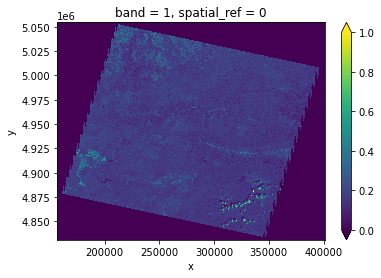

In [86]:
xr.plot.imshow(test_ds.sel(band=1)*0.0000275-.2, vmin=0, vmax=1)

Due to memory constraints we'll average repeated captures of the same scene. Then we'll average all of those averaged scenes together to create the full mesh. As of now we're just doing a straight average but ideally we would carry the weights of the number of repeats of each scene and do a weighted average when quilting the scenes together.


In [2]:
access_key_id, secret_access_key = access_credentials()

Then we take the list of files for a given year to average across growing season for each of the tiles and write it out to a mapper with those specifications.

In [3]:
dask.config.set({"array.slicing.split_large_chunks": True})

In [4]:
gdf = gpd.read_file('https://prd-wret.s3-us-west-2.amazonaws.com/assets/'
                   'palladium/production/s3fs-public/atoms/files/'
                   'WRS2_descending_0.zip')

In [5]:
washington_scenes = gdf.cx[-125:-115,45:49]

In [6]:

# @dask.delayed(pure=True, traverse=False)
def scene_seasonal_average(path, row, year, bucket, access_key_id, secret_access_key,
                           bands_of_interest='all', season='JJA'):
    '''
    Given location/time specifications will grab all valid scenes,
    mask each according to its time-specific cloud QA and then 
    return average across all masked scenes

    Parameters
    ----------
    path: int
        the integer value for the scene's path (the swath, like longitude)
    row: int
        the integer value for the scene's row (location like latitude)
    year: int
        the calendar year you're processing- currently only working on boreal summer.
    bucket: str
        The path to where your outputs will be written.
    access_key_id : str
        Key ID for AWS credentials
    secret_access_key : str
        Secret access key for AWS credentials
    bands_of_interest : list
        List of the bands you want to process. If none is specified it will use all six.
    season: str
        Season to process. Currently only boreal summer is supported.

    Returns
    -------
    url: str
        The path where your dataset is getting written.
    '''
    aws_session = AWSSession(boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key),
                            requester_pays=True)#profile_name='default'), requester_pays=True) 
    fs = S3FileSystem(key=access_key_id,
                    secret=secret_access_key, requester_pays=True)

    with dask.config.set(scheduler='single-threaded'): # this? **** #threads #single-threaded # threads??
        with rio.Env(aws_session):
            test_credentials(aws_session)
        #             print('it works!')

            # set where you'll save the final seasonal average
            url = f'{bucket}{path}/{row}/{year}/{season}_reflectance.zarr'
            mapper = fs.get_mapper(url) #used to be fsspec
            # all of this is just to get the right formatting stuff to access the scenes

            landsat_bucket = 's3://usgs-landsat/collection02/level-2/standard/tm/{}/{:03d}/{:03d}/'
            month_keys = {'JJA': ['06', '07', '08']}
            valid_files, ds_list = [], []

            if bands_of_interest=='all':
                bands_of_interest = ['SR_B1', 'SR_B2', 'SR_B3', 
                                         'SR_B4', 'SR_B5', 'SR_B7']
            scene_stores = fs.ls(landsat_bucket.format(year, path, row))
            summer_datestamps = ['{}{}'.format(year, month) for month in month_keys[season]]
            for scene_store in scene_stores:
                for summer_datestamp in summer_datestamps:
                    if summer_datestamp in scene_store:
                        valid_files.append(scene_store)
            for file in valid_files:
                scene_id = file[-40:]
                url = 's3://{}/{}'.format(file, scene_id)
                utm_zone = get_scene_utm_zone(url)
                cloud_mask_url = url+'_SR_CLOUD_QA.TIF'
                cog_mask = cloud_qa(cloud_mask_url)
                ds_list.append(grab_ds(url, bands_of_interest, cog_mask, utm_zone))
            
            seasonal_average = average_stack_of_scenes(ds_list)
            
            write_out(seasonal_average.chunk({'band': 6, 'x': 1024, 'y': 1024}), mapper)
            return url

In [16]:
bucket = 's3://carbonplan-climatetrace/v1/'
# PANGEO_SCRATCH=os.environ['PANGEO_SCRATCH_PREFIX']+'/orianac/'
tasks=[]
rerun=True
if rerun:
    with rio.Env(aws_session): # delete
#         for every year in GLAS record
        for year in np.arange(2003,2004):#2009):
            # for every row path in the domain
            for [path, row] in washington_scenes[['PATH', 'ROW']].values[0:2]:
                for season in ['JJA']:
                        tasks.append(
                            client.compute(
                        scene_seasonal_average(path, row, year, bucket, access_key_id, 
                                               secret_access_key,
                                                              bands_of_interest='all',
                                                              season=season),
                            retries=4))

In [17]:
tasks

[<Future: pending, key: scene_seasonal_average-4b7f8478312e71c3b5e4d81584688d5f>,
 <Future: pending, key: scene_seasonal_average-cac1da22a9226b57d1855f10e594a247>]

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1125)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [9]:
# this is a good test on one cell to see it's working
url='s3://carbonplan-climatetrace/v1/'
ds = scene_seasonal_average(46, 27, 2005, url, access_key_id, secret_access_key)#, aws_session)#.chunk({'band': 6, 'x': 1024, 'y': 1024})

NameError: name 'cloud_qa' is not defined

In [23]:
washington_scenes = add_landsat_utm_zone(washington_scenes)

### Now that you've inspected the landsat scenes,make sure you have the correct utm zones for each row/path combo, because sometimes they use one that is not what you would expect. For now we'll just do it once, but should probs check that it doesn't change year-to-year

# TODO:
* ~fix why the attrs aren't working in zarr~
* ~rerun all of the washington state scenes~

THEN
* ~add column for utm in the scene shapefile~
* ~loop through all scenes, grab utm from sample file and fill into df~
* ~then use that column to force the projection~
* rerun the projections and create biomass dataframe

### Now let's link with GLAS. We'll loop through every 10x10 degree GLAS tile and repeat this process

### copy over single biomass tile

In [48]:
copy=False
if copy:
    source_mapper = fsspec.get_mapper('gs://carbonplan-climatetrace/intermediates/biomass/50N_120W.zarr')
    # url = os.environ['PANGEO_SCRATCH_PREFIX']+'/orianac/'
    url = 's3://carbonplan-climatetrace/v1/'
    dest_mapper = fs.get_mapper('carbonplan-climatetrace/v1/biomass/50N_120W.zarr')
    # fsspec.get_mapper(url+'biomass/50N_120W.zarr', storage_options={'profile': 'default'})
    ds = xr.open_zarr(source_mapper)
    ds = ds.drop('allometric_eq')
    with dask.config.set(scheduler='threads'): # this? **** #threads #single-threaded
        ds.to_zarr(dest_mapper, mode='w', consolidated=True)

### Load in the biomass dataset for this one tile

In [24]:
ul_lat, ul_lon = 50, 120
file_mapper = fs.get_mapper('carbonplan-climatetrace/v1/biomass/{}N_{}W.zarr'.format(ul_lat, ul_lon))
# biomass = xr.open_zarr(PANGEO_SCRATCH+'biomass/{}N_{}W.zarr'.format(ul_lat, ul_lon), consolidated=True).load()

biomass = xr.open_zarr(file_mapper, consolidated=True).load().drop('spatial_ref')
biomass_df = biomass.stack(unique_index=("record_index", "shot_number")).to_dataframe().dropna(how='all')

### Convert it to a geodataframe and attach the landsat row/col info to it. This will form the mapping from IceSAT to Landsat.

In [25]:
biomass_gdf = gpd.GeoDataFrame(
    biomass_df, geometry=gpd.points_from_xy(biomass_df.lon, biomass_df.lat)).set_crs("EPSG:4326")
linked_gdf = gpd.sjoin(biomass_gdf, 
                       washington_scenes, #gdf.cx[-125:-115,45:49], # gdf.cx[-ul_lon:-ul_lon+10,ul_lat-10:ul_lat], 
                       how='inner') # 'left' # by selecting inner you're grabbing the intersection (so dropping any shots 
#that don't have scenes or scenes that don't have shots)

### Now you have the row and path for each shot. Let's now get the url to the appropriate COG. For this we'll need the 

In [27]:
def convert_to_utm(df):
    return utm.from_latlon(df['lat'], df['lon'], force_zone_number=df['landsat_utm_zone'])

In [28]:
def add_projection_info(df):
    projection_info = df.apply(convert_to_utm, axis=1).to_list()
    projected_column_names = ['proj_x', 'proj_y', 'utm_zone', 'utm_letter']
    projection_df = pd.DataFrame(projection_info, columns=projected_column_names, index=df.index)
    updated_df = pd.concat([df, projection_df], axis=1)
    return updated_df

In [29]:
def grab_year(df):
    return datetime.fromtimestamp(df['time']).year

In [30]:
def add_linking_info(df):
    df = add_projection_info(df)
    df['year'] = df.apply(grab_year, axis=1)
    df['url'] = df.apply(build_url, axis=1)
    return df

In [31]:
def build_url(df):
    return 's3://carbonplan-climatetrace/v1/{}/{}/{}/JJA_reflectance.zarr'.format(df['PATH'], 
                                                                                   df['ROW'], 
                                                                                   df['year'])

In [32]:
linked_gdf = add_linking_info(linked_gdf)

Do all unique row/path/year combos at same time since they'll be grabbing the same file.
Open the file and loop through each x/y location to get reflectance values

In [37]:
unique_urls = linked_gdf['url'].unique()

In [33]:
def create_combined_landsat_biomass_df(landsat_ds, biomass_df, 
                                       biomass_variables=['biomass', 'glas_elev', 'ecoregion']):
    selected_landsat = landsat_ds.sel(x=xr.DataArray(biomass_df['proj_x'].values, dims='shot'), 
                      y=xr.DataArray(biomass_df['proj_y'].values, dims='shot'),
                      method='nearest').to_dataframe().drop(['x', 'y'], axis=1)
    selected_landsat.index = biomass_df.index
    out_df = pd.concat([biomass_df[biomass_variables], selected_landsat], axis=1)
    return out_df

In [148]:
washington_row_path_strings = ['{}/{}'.format(row, path) for (row, path) in washington_row_paths]

In [66]:
wr.s3.to_parquet(
    df=washington_df, index=True,
    path='s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet', 
    boto3_session=boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key)
)

{'paths': ['s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet'],
 'partitions_values': {}}

In [67]:
washington_dfs = []
# group the biomass shots according to the scene they overlap
groupby = linked_gdf.groupby('url')
for year in np.arange(2003,2009):
    for (i, (path, row)) in washington_scenes[['PATH', 'ROW']].iterrows():
        for season in ['JJA']:
            url = f'{bucket}{path}/{row}/{year}/{season}_reflectance.zarr'
            try:
                shots_one_scene = groupby.get_group(url)
                ds = xr.open_zarr(fs.get_mapper(url)).drop('spatial_ref').reflectance.to_dataset(dim='band')
                washington_dfs.append(create_combined_landsat_biomass_df(ds, shots_one_scene))
            except:
                print('{} had no shots'.format(url))
washington_df = pd.concat(washington_dfs)
wr.s3.to_parquet(
    df=washington_df, index=True,
    path='s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet', 
    boto3_session=boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key)
)

s3://carbonplan-climatetrace/v1/45/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/28/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/28/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/49/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/49/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/47/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/47/27/2003/JJA_reflectance.zarr had no shots

{'paths': ['s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet'],
 'partitions_values': {}}

In [105]:
selected_landsat = ds.sel(x=xr.DataArray(shots_one_scene['proj_x'].values, dims='shot'), 
      y=xr.DataArray(shots_one_scene['proj_y'].values, dims='shot'),
      method='nearest').to_dataframe().drop(['x', 'y'], axis=1)
selected_landsat.index = shots_one_scene.index

Landsat is in meters with the utm projection of that path/row (need to check for weirdness at utm boundaries).
So, if we give it meters locations we can get back the values from dataset.

In [84]:
x=376435
y=5409203
ds.sel(x=x, y=y, method='nearest').reflectance.values

array([ 8216.33333333,  8869.33333333,  8687.        , 16541.33333333,
       12305.66666667,  9986.66666667])

What we need to do now is make a column of projected x/y in the dataframe